## Import

import pyodbc
print(pyodbc.drivers())


In [73]:
from sqlalchemy import create_engine
import urllib

server = "localhost\SQLEXPRESS"
database = "db_Churn"
driver = "ODBC Driver 18 for SQL Server"

params = urllib.parse.quote_plus(
    f"DRIVER={driver};"
    f"SERVER={server};"
    f"DATABASE={database};"
    "Trusted_Connection=yes;"
    "Encrypt=yes;"
    "TrustServerCertificate=yes;"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")



## Data Loading

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib


data = pd.read_sql("SELECT * FROM dbo.vw_ChurnData", engine)
data.head()



,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,True,Madhya Pradesh,0,31,Deal 1,Yes,No,...,Bank Withdrawal,95.099998,6683.399902,0.00,0,631.719971,7315.120117,Stayed,Others,Others
1,11114-PUN,Male,51,False,Punjab,5,9,Deal 5,Yes,No,...,Bank Withdrawal,49.150002,169.050003,0.00,10,122.370003,301.420013,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,True,West Bengal,3,28,Deal 1,Yes,Yes,...,Bank Withdrawal,116.050003,8297.500000,42.57,110,1872.979980,10237.910156,Stayed,Others,Others
3,11179-MAH,Male,35,False,Maharashtra,10,12,None,Yes,No,...,Credit Card,84.400002,5969.299805,0.00,0,219.389999,6188.689941,Stayed,Others,Others
4,11180-TAM,Male,75,True,Tamil Nadu,12,27,Deal 2,Yes,No,...,Credit Card,72.599998,4084.350098,0.00,140,332.079987,4556.430176,Stayed,Others,Others


##  Data Preprocessing


In [75]:
# Drop columns that won't be used for prediction
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

# List of columns to be label encoded
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

 

# Encode categorical variables except the target variable
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

 
# Manually encode the target variable 'Customer_Status'
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

 
# Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ,  stratify=y)

 ## Model Training (Random Forest)

In [76]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    max_depth=10,
    min_samples_leaf=10
)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, n_estimators=300, random_state=42)

## Model Evaluation & Feature Engineering

Confusion Matrix:
[[812  43]
 [138 209]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       855
           1       0.83      0.60      0.70       347

    accuracy                           0.85      1202
   macro avg       0.84      0.78      0.80      1202
weighted avg       0.85      0.85      0.84      1202



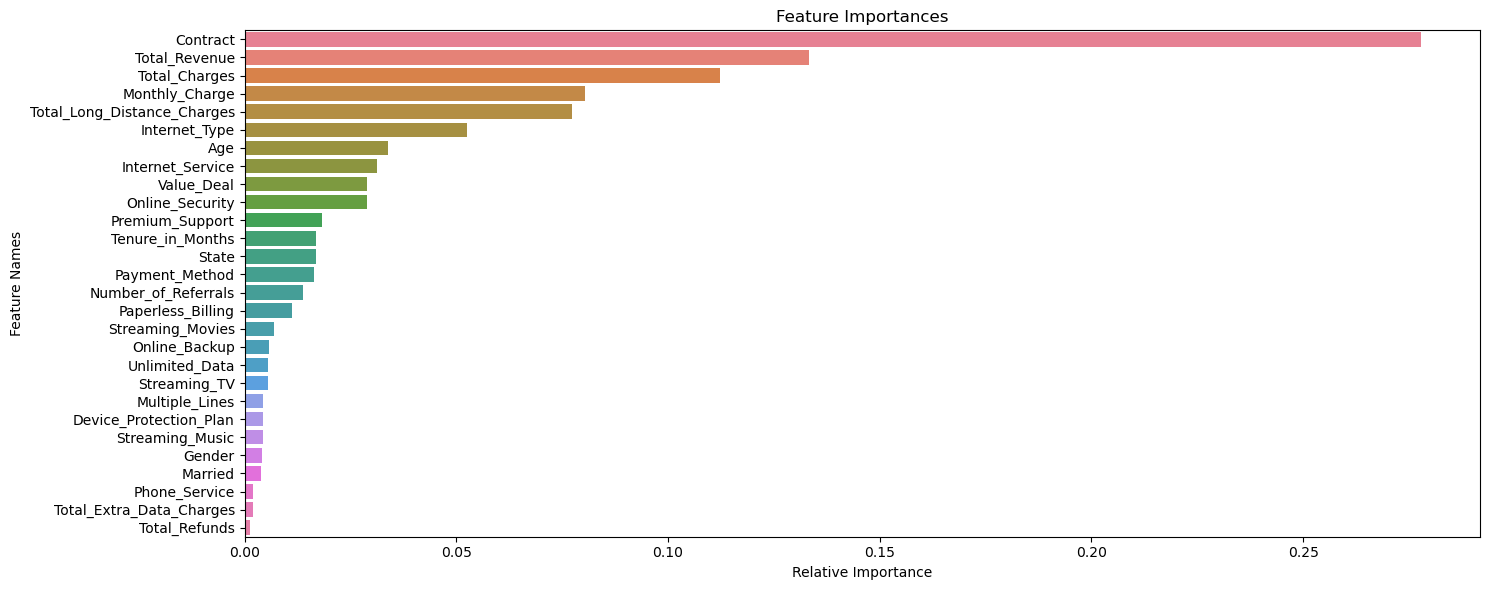

In [77]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]


# Plot the feature importances
plt.figure(figsize=(15, 6))

palette = sns.color_palette("husl", len(indices))   # mixed distinct colors

sns.barplot(
    x=importances[indices],
    y=X.columns[indices],
    hue=X.columns[indices],       # required to avoid FutureWarning
    dodge=False,
    palette=palette,
    legend=False
)

plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.tight_layout()
plt.show()


## Churn Prediction And Export

In [78]:

# Use Model for Prediction on New Data
new_data = pd.read_sql("SELECT * FROM dbo.vw_JoinData", engine)

# Display the first few rows of the fetched data
print(new_data.head())

# Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy()

# Retain the Customer_ID column
customer_ids = new_data['Customer_ID']

# Drop columns that won't be used for prediction in the encoded DataFrame
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)
 
# Encode categorical variables using the saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])

# Make predictions
new_predictions = rf_model.predict(new_data)
 
# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions

# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

# Save the results
original_data.to_csv(r"C:\Users\HP\Documents\Power_BI_All_Dashboards\Data & Resources\Data\Predictions.csv", index=False)

  Customer_ID  Gender  Age  Married        State  Number_of_Referrals  \
0   11751-TAM  Female   18    False   Tamil Nadu                    5   
1   12056-WES    Male   27    False  West Bengal                    2   
2   12136-RAJ  Female   25     True    Rajasthan                    2   
3   12257-ASS  Female   39    False        Assam                    9   
4   12340-DEL  Female   51     True        Delhi                    0   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7     Deal 5            No             No  ...   
1                20       None           Yes             No  ...   
2                35       None           Yes             No  ...   
3                 1       None           Yes             No  ...   
4                10       None           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      24.299999     38.450001           0.0   
1  Bank Withdrawal    